In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler,  OrdinalEncoder
from my_functions import filter_columns_from_data_source

pd.set_option('display.max_columns', None)
# read the data from https://pslcdatashop.web.cmu.edu/DatasetInfo?datasetId=579 
# 
#df_data=pd.read_csv("survey_results_public.csv")
my_selected_columns=[ 
    "AISent",
    "AISearchDevHaveWorkedWith", # list of tool selection
    "AISearchDevWantToWorkWith", # list of tool selection
    "WorkExp",
    "ConvertedCompYearly",
    "JobSat"
]

df_filtered=filter_columns_from_data_source(my_selected_columns,"survey_results_public.csv")
df_filtered.info()
df_filtered.describe()

print(df_filtered["AISent"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65437 entries, 0 to 65436
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AISent                     45873 non-null  object 
 1   AISearchDevHaveWorkedWith  44453 non-null  object 
 2   AISearchDevWantToWorkWith  36701 non-null  object 
 3   WorkExp                    29658 non-null  float64
 4   ConvertedCompYearly        23435 non-null  float64
 5   JobSat                     29126 non-null  float64
dtypes: float64(3), object(3)
memory usage: 3.0+ MB
['Very favorable' nan 'Favorable' 'Indifferent' 'Unsure'
 'Very unfavorable' 'Unfavorable']


In [2]:
# target is to look for correlation between number of AI search and development tools used and years of work experience, income job satisfaction
df_filtered_ext=df_filtered
df_filtered_ext["NoOfAIToolsWorkedWith"]=df_filtered["AISearchDevHaveWorkedWith"].apply(lambda item : len(item.split(";")) if isinstance(item, str) else 0)
df_filtered_ext["NoOfAIToolsWanToWorkWith"]=df_filtered["AISearchDevWantToWorkWith"].apply(lambda item : len(item.split(";")) if isinstance(item, str) else 0)

df_num=df_filtered_ext.drop(["AISearchDevHaveWorkedWith","AISearchDevWantToWorkWith"],axis=1)

# remove nan
df_clean=df_num.dropna(how="any")

# check all attitudes towards AI contained
print(df_clean["NoOfAIToolsWanToWorkWith"].unique())
df_clean.info()



[ 1  3  0  4  2  5  7  6  8 25 11 10  9 17 18 14 12 24]
<class 'pandas.core.frame.DataFrame'>
Index: 12291 entries, 72 to 41186
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AISent                    12291 non-null  object 
 1   WorkExp                   12291 non-null  float64
 2   ConvertedCompYearly       12291 non-null  float64
 3   JobSat                    12291 non-null  float64
 4   NoOfAIToolsWorkedWith     12291 non-null  int64  
 5   NoOfAIToolsWanToWorkWith  12291 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 672.2+ KB


In [3]:
ordinal_encoder=OrdinalEncoder()

df_clean["AISent"]=ordinal_encoder.fit_transform(df_clean[["AISent"]])

df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 12291 entries, 72 to 41186
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AISent                    12291 non-null  float64
 1   WorkExp                   12291 non-null  float64
 2   ConvertedCompYearly       12291 non-null  float64
 3   JobSat                    12291 non-null  float64
 4   NoOfAIToolsWorkedWith     12291 non-null  int64  
 5   NoOfAIToolsWanToWorkWith  12291 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 672.2 KB


/tmp/ipykernel_709/3868492740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["AISent"]=ordinal_encoder.fit_transform(df_clean[["AISent"]])


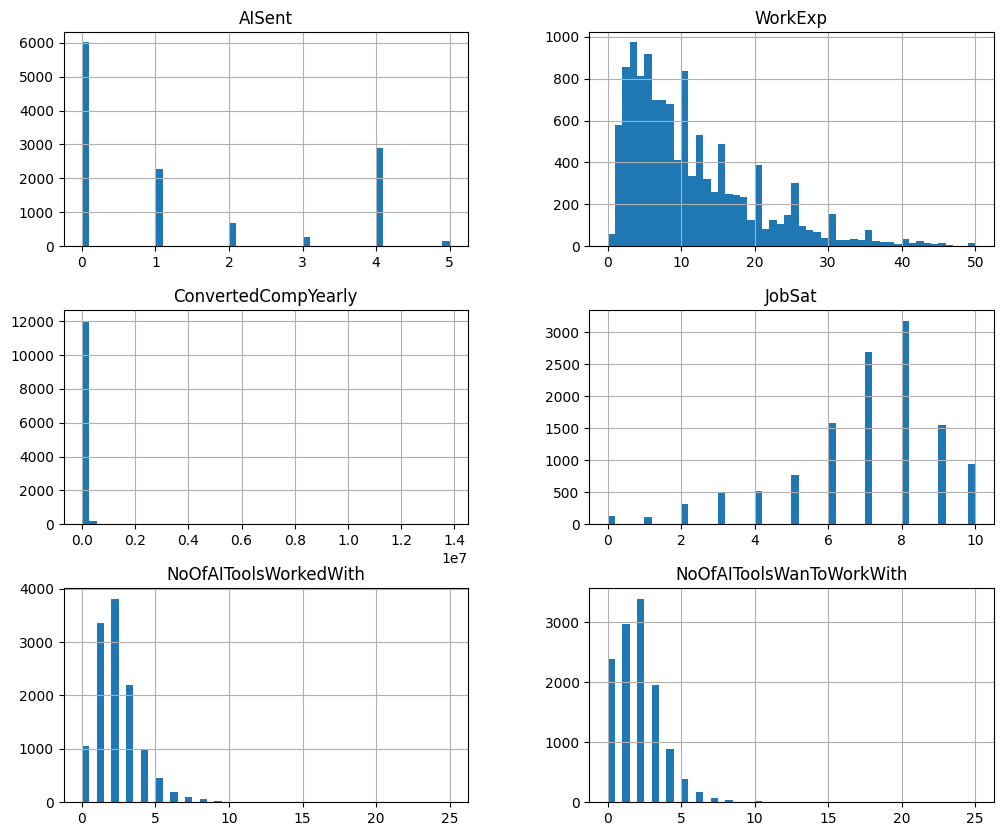

In [4]:
# plot histograms of the features with matplotlib to see their distributions
df_clean.hist(bins=50, figsize=(12, 10))
plt.show()


In [5]:
# analyse correlations
corr_matrix=df_clean.corr()
# Print the correlation matrix sorted by linear correlation with the target
corr_matrix["NoOfAIToolsWanToWorkWith"].sort_values(ascending=False)


NoOfAIToolsWanToWorkWith    1.000000
NoOfAIToolsWorkedWith       0.570135
AISent                      0.056433
JobSat                      0.017379
ConvertedCompYearly         0.016759
WorkExp                    -0.040642
Name: NoOfAIToolsWanToWorkWith, dtype: float64

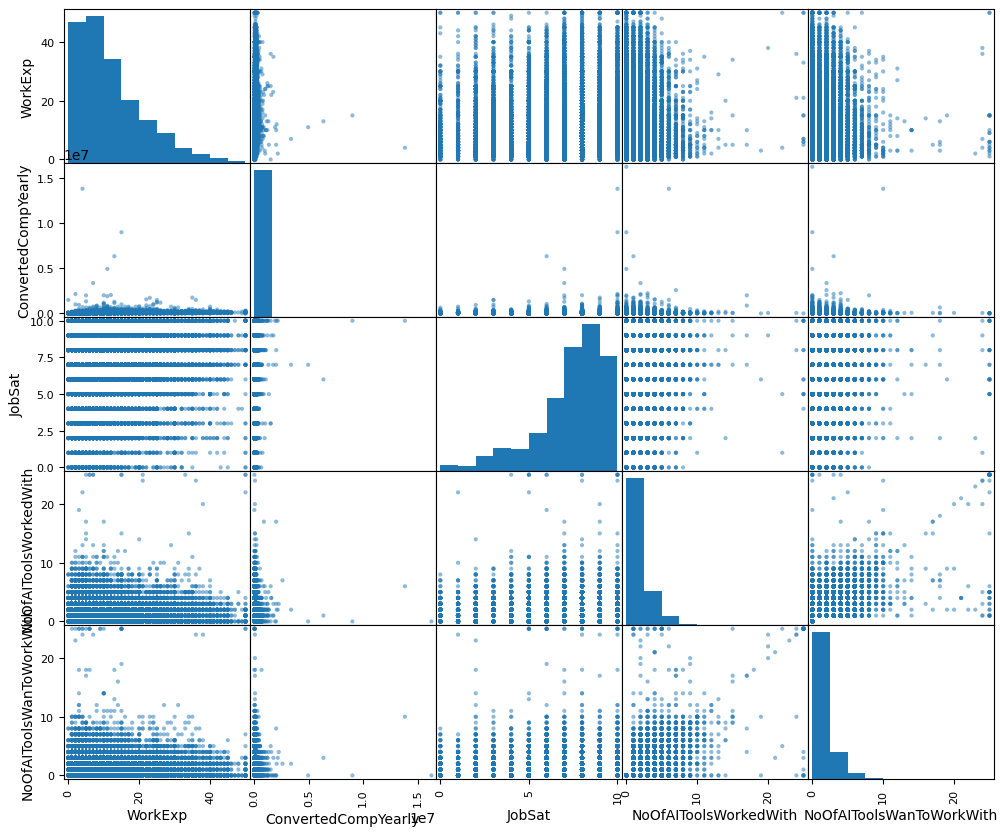

In [6]:
scatter_matrix(df_num, figsize=(12, 10))
plt.show()

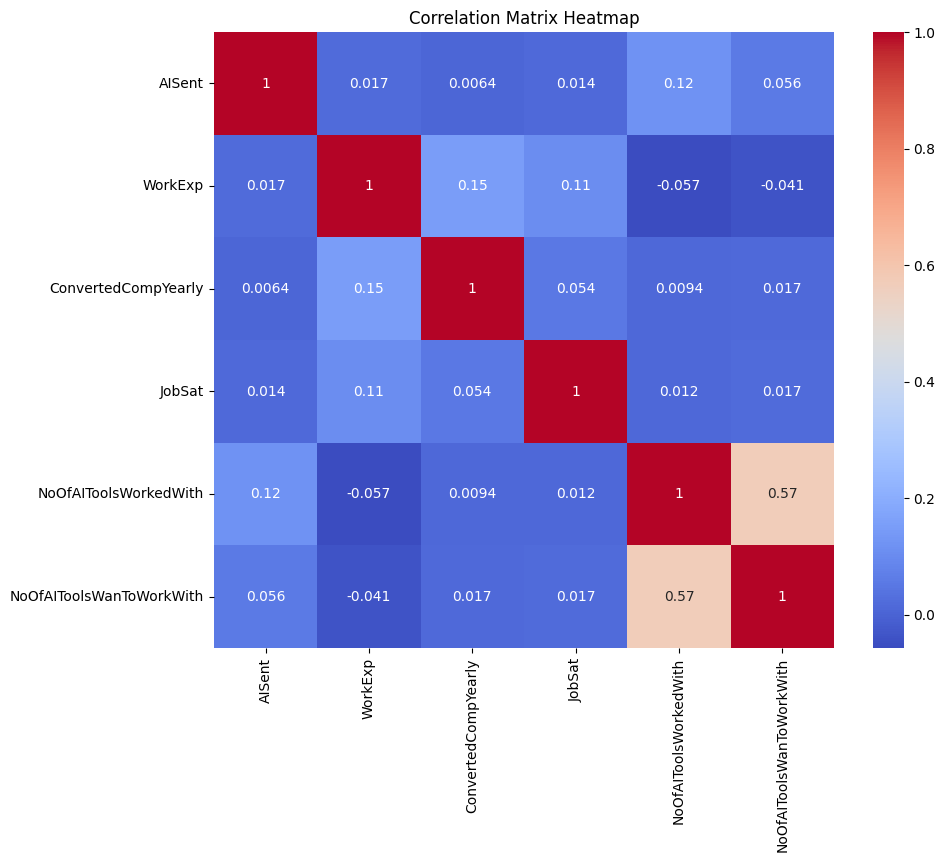

In [7]:
# plot heat map for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [8]:
# try linear regression model 
y=df_clean["NoOfAIToolsWanToWorkWith"]
X=df_clean.drop(["NoOfAIToolsWanToWorkWith"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [9]:
linear_predictions_train = linear_model.predict(X_train)
linear_predictions_test = linear_model.predict(X_test)
# Calculate the root mean squared error on the training and test set
rmse_train = root_mean_squared_error(y_train, linear_predictions_train)
print(rmse_train)
rmse_test = root_mean_squared_error(y_test, linear_predictions_test)
print(rmse_test)

1.3970787377230292
1.3045377133753557


In [10]:
# because of the comparable and low error and the good correlation between the no of AITools worked with with the number of tools want to work with, a simple model with just one paraemter can be used
X_train_simple=X_train[["NoOfAIToolsWorkedWith"]]
X_test_simple=X_test[["NoOfAIToolsWorkedWith"]]

simple_model=LinearRegression()
simple_model.fit(X_train_simple, y_train)


LinearRegression()

In [11]:
X_train.info()



<class 'pandas.core.frame.DataFrame'>
Index: 9832 entries, 26572 to 9150
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AISent                 9832 non-null   float64
 1   WorkExp                9832 non-null   float64
 2   ConvertedCompYearly    9832 non-null   float64
 3   JobSat                 9832 non-null   float64
 4   NoOfAIToolsWorkedWith  9832 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 460.9 KB


In [12]:
simple_predictions_train = simple_model.predict(X_train_simple)
simple_predictions_test = simple_model.predict(X_test_simple)
# Calculate the root mean squared error on the training and test set
rmse_train_simple = root_mean_squared_error(y_train, simple_predictions_train)
print(rmse_train_simple)
rmse_test_simple = root_mean_squared_error(y_test, simple_predictions_test)
print(rmse_test_simple)

1.3977440621913584
1.303681768145889


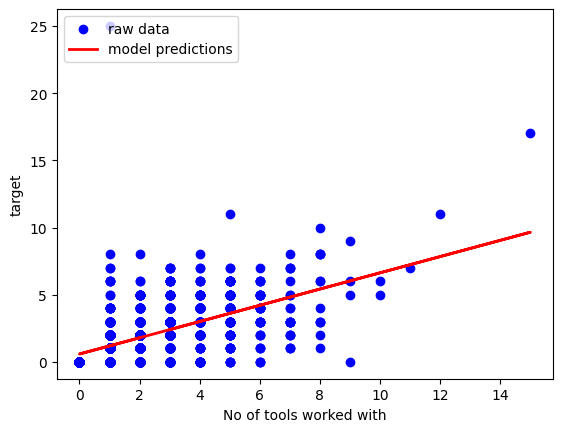

In [13]:
# There is only a correlation between the number of tools used and the tools used
# Plot the simple linear regression model
plt.scatter(X_test_simple, y_test, color='blue', label='raw data')
plt.plot(X_test_simple, simple_predictions_test, color='red', linewidth=2, label='model predictions')
plt.xlabel("No of tools worked with")
plt.ylabel("target")
plt.legend(loc="upper left")
plt.show()